In [61]:
import sys
sys.path.insert(1, '/users/facsupport/asharma/RNN-shifts/preprocessing')

from data_prep import initial_preprocess

### Generate dataset

RAW_DATA_PATH = '/export/storage_adgandhi/PBJ_data_prep/pbj_full.csv'
PREPROCESSED_DIR = '/users/facsupport/asharma/Data/test'

df, info = initial_preprocess(
    RAW_DATA_PATH, PREPROCESSED_DIR,
    nrows=100000,  
    fill_missing_shifts=True,
    normalize=False,
    day_of_week=True,
    prev_shifts=30,
    fac_data=True
)
df
print(df.columns)

Loading preprocessed data from '/users/facsupport/asharma/Data/testpbj_nrows_100000_zeros_prev_shifts_30_dow_fac.csv'...
Loading related info from '/users/facsupport/asharma/Data/testpbj_nrows_100000_zeros_prev_shifts_30_dow_fac.info.csv'...
Index(['t_0', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9',
       't_10', 't_11', 't_12', 't_13', 't_14', 't_15', 't_16', 't_17', 't_18',
       't_19', 't_20', 't_21', 't_22', 't_23', 't_24', 't_25', 't_26', 't_27',
       't_28', 't_29', 't_30', 'hours', 'employee_id', 'date', 'job_title',
       'prov_id', 'pay_type', 'day_of_week', 'nresid', 'multifac', 'profit',
       'avg_dailycensus', 'sd_dailycensus'],
      dtype='object')


In [62]:
import pandas as pd
import lightgbm as lgb

# Keep "interesting" jobs (TODO - use strings instead)
df = df[df['job_title'].isin([33,34,35,11,12,3,5,16,17])]
df['date'] = pd.to_datetime(df['date']).astype(int)
# Convert necessary values to boolean
df.multifac = df.multifac.map(dict(Yes=1, No=0))
df.profit = df.profit.map(dict(Yes=1, No=0))
#Drop employee id and date columns
df = df.drop(columns=['employee_id','date'])

# %%
# ========================================
#          SPLIT & PREP DATAFRAME
# ========================================

inputs = df.drop(['t_0', 'hours'], axis=1)
labels = df.filter(['t_0'])

# Weights to split data set
TRAINING_WEIGHT = 0.7
VALIDATION_WEIGHT = 0.2
TEST_WEIGHT = 0.1

n = len(df)
weights_sum = TRAINING_WEIGHT + VALIDATION_WEIGHT + TEST_WEIGHT
split1 = int(TRAINING_WEIGHT / weights_sum * n)
split2 = int((TRAINING_WEIGHT + VALIDATION_WEIGHT) / weights_sum * n)

train_inputs, train_labels = inputs[:split1], labels[:split1]
val_inputs, val_labels = inputs[split1:split2], labels[split1:split2]
test_inputs, test_labels = inputs[split2:], labels[split2:]

print(train_inputs)
print(train_labels)


        t_1   t_2   t_3   t_4   t_5   t_6   t_7   t_8   t_9  t_10  ...  t_30  \
0      7.50  0.00  0.00  8.25  8.00  7.75  7.50  0.00  0.00  8.00  ...  7.50   
1      7.75  7.50  0.00  0.00  8.25  8.00  7.75  7.50  0.00  0.00  ...  7.75   
2      8.00  7.75  7.50  0.00  0.00  8.25  8.00  7.75  7.50  0.00  ...  7.75   
3      8.00  8.00  7.75  7.50  0.00  0.00  8.25  8.00  7.75  7.50  ...  0.00   
4      0.00  8.00  8.00  7.75  7.50  0.00  0.00  8.25  8.00  7.75  ...  0.00   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
46722  7.25  7.50  7.75  8.25  8.50  0.00  0.00  8.25  7.75  7.75  ...  8.00   
46723  0.00  7.25  7.50  7.75  8.25  8.50  0.00  0.00  8.25  7.75  ...  8.00   
46724  0.00  0.00  7.25  7.50  7.75  8.25  8.50  0.00  0.00  8.25  ...  0.00   
46725  0.00  0.00  7.75  7.75  7.50  7.50  0.00  0.00  8.00  7.75  ...  7.75   
46726  7.50  0.00  0.00  7.75  7.75  7.50  7.50  0.00  0.00  8.00  ...  7.50   

       job_title  prov_id  pay_type  da

In [63]:
# %%
# ========================================
#          DATAFRAME TO LGB DS
# ========================================

cats = ['job_title', 'prov_id', 'pay_type', 'day_of_week', 'nresid', 'multifac', 'profit']

train_data = lgb.Dataset(train_inputs, label=train_labels, categorical_feature=cats)
val_data = lgb.Dataset(val_inputs, label=val_labels, categorical_feature=cats)
test_data = lgb.Dataset(test_inputs, label=test_labels, categorical_feature=cats)
print(train_data)

In [64]:
# %%
# ========================================
#            TRAIN WITH LGB
# ========================================
param = {
   'num_leaves': 200,
   'learning_rate': 0.05,
   'metric': 'mse',
   'boosting': 'gbdt',
}
evals_result = {}
bst = lgb.train(param, train_data, valid_sets=[val_data], evals_result=evals_result, early_stopping_rounds=5)

/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.172602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7735
[LightGBM] [Info] Number of data points in the train set: 46727, number of used features: 39
[LightGBM] [Info] Start training from score 4.764275


/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/users/facsupport/asharma/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's l2: 18.1443
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 17.4182
[3]	valid_0's l2: 16.7676
[4]	valid_0's l2: 16.1578
[5]	valid_0's l2: 15.6158
[6]	valid_0's l2: 15.1289
[7]	valid_0's l2: 14.6811
[8]	valid_0's l2: 14.2772
[9]	valid_0's l2: 13.9105
[10]	valid_0's l2: 13.5799
[11]	valid_0's l2: 13.2721
[12]	valid_0's l2: 12.9798
[13]	valid_0's l2: 12.7205
[14]	valid_0's l2: 12.482
[15]	valid_0's l2: 12.2696
[16]	valid_0's l2: 12.0673
[17]	valid_0's l2: 11.8766
[18]	valid_0's l2: 11.7008
[19]	valid_0's l2: 11.5332
[20]	valid_0's l2: 11.3938
[21]	valid_0's l2: 11.2579
[22]	valid_0's l2: 11.1357
[23]	valid_0's l2: 11.0284
[24]	valid_0's l2: 10.933
[25]	valid_0's l2: 10.8388
[26]	valid_0's l2: 10.7529
[27]	valid_0's l2: 10.6699
[28]	valid_0's l2: 10.5969
[29]	valid_0's l2: 10.5216
[30]	valid_0's l2: 10.461
[31]	valid_0's l2: 10.4111
[32]	valid_0's l2: 10.3436
[33]	valid_0's l2: 10.2899
[34]	valid_0's l2: 10.236
[35]	valid_0's l2: 10.1957
[36]	val

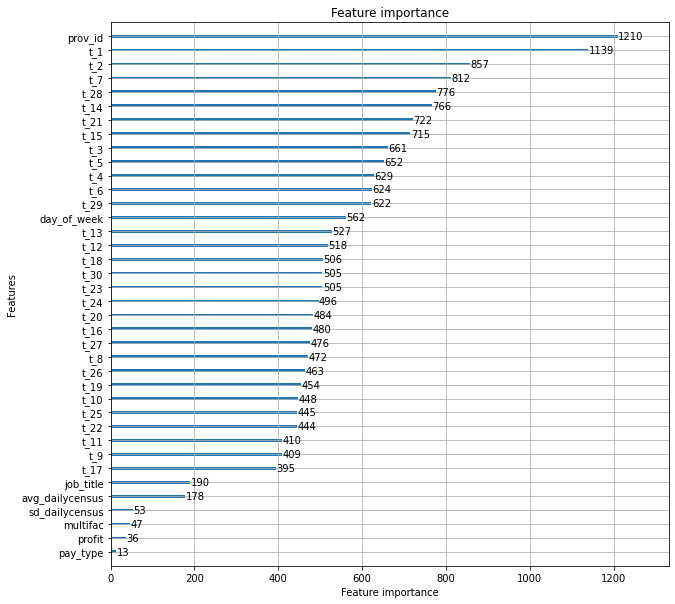

In [65]:
# %%
# =========================================
#          LGB Influence Scores
# =========================================

axes = lgb.plot_importance(bst,figsize=(10,10))

In [66]:
pd.unique(df['prov_id'])

array([ 5, 13, 12,  8,  3,  9, 15, 11,  7,  6, 10,  1, 14,  4,  2])

In [67]:
pd.unique(df['avg_dailycensus'])

array([ 56.15,  96.99, 133.11,  86.62,  37.  ,  94.99,  90.4 ,  59.32,
        68.62, 103.55,  86.47,  34.1 ,  42.39,  55.72,  55.91])

In [68]:
predictions = bst.predict(test_inputs)
MAE=0
RMSE = 0

for i in range(len(test_labels)):
    #mean = info['means.hours']
    #std = info['stds.hours']
    #prediction = predictions[i]*std + mean
    #value = test_labels.iloc[i]['t_0']*std + mean
    prediction = predictions[i]
    value = test_labels.iloc[i]['t_0']
    print(f"Prediction: {prediction} True Value: {value}")
    MAE += abs(prediction-value)
    RMSE += (prediction-value)**2
    
print(f"Mean absolute error {MAE/len(test_labels)}")
print(f"Root mean squared error {(RMSE/len(test_labels))**0.5}")

Prediction: 3.061041105408244 True Value: 0.0
Prediction: 5.230780097341581 True Value: 0.0
Prediction: 6.749303660096027 True Value: 7.93
Prediction: 7.736905075205347 True Value: 7.73
Prediction: 3.0039185283314027 True Value: 8.67
Prediction: 4.477149058723548 True Value: 0.0
Prediction: 3.5797275438721354 True Value: 7.68
Prediction: 7.450776006208219 True Value: 7.72
Prediction: 8.372297438965965 True Value: 7.82
Prediction: 4.719247620262148 True Value: 0.0
Prediction: 5.257545660284207 True Value: 0.0
Prediction: 5.239273071185941 True Value: 0.0
Prediction: 2.9114155612187025 True Value: 0.0
Prediction: 1.2055122611802924 True Value: 0.0
Prediction: 0.9358992238608931 True Value: 0.0
Prediction: 3.5257923782919804 True Value: 0.0
Prediction: 2.811296790448717 True Value: 7.77
Prediction: 6.715616266895618 True Value: 8.38
Prediction: 6.3131917533202095 True Value: 0.17
Prediction: 5.24417764535186 True Value: 0.0
Prediction: 5.170119528967268 True Value: 7.9
Prediction: 7.99136

Prediction: 7.146155672486012 True Value: 7.5
Prediction: 5.629589906954077 True Value: 7.5
Prediction: 1.6633812394051763 True Value: 0.0
Prediction: 1.1204315477858622 True Value: 0.0
Prediction: 4.987126201388831 True Value: 7.5
Prediction: 7.755451293411423 True Value: 8.0
Prediction: 7.781463327788838 True Value: 7.75
Prediction: 1.4564348867907584 True Value: 8.0
Prediction: 1.189843158038468 True Value: 0.0
Prediction: 0.16090724530762093 True Value: 0.0
Prediction: 7.790525240644307 True Value: 8.25
Prediction: 7.371671669319752 True Value: 7.75
Prediction: 7.649855497135408 True Value: 8.0
Prediction: 7.794109598742642 True Value: 8.0
Prediction: 7.109828910395 True Value: 0.0
Prediction: 1.5632937892552872 True Value: 0.0
Prediction: 0.21327826421536164 True Value: 0.0
Prediction: 6.52931953634039 True Value: 8.25
Prediction: 7.987634481440247 True Value: 9.25
Prediction: 7.810935580268748 True Value: 5.0
Prediction: 6.214897736650743 True Value: 7.75
Prediction: 6.2114385671

Prediction: 6.615118422792862 True Value: 10.5
Prediction: 6.140592307708414 True Value: 7.75
Prediction: 5.874811661373928 True Value: 0.0
Prediction: 1.6686389084458755 True Value: 0.0
Prediction: 1.3734069906633082 True Value: 7.75
Prediction: 6.294602832426733 True Value: 7.75
Prediction: 6.875039781033513 True Value: 0.0
Prediction: 3.875916452116833 True Value: 0.0
Prediction: 3.2986185317054337 True Value: 7.75
Prediction: 4.170477596044845 True Value: 0.0
Prediction: 2.765622387305683 True Value: 0.0
Prediction: 3.955050581035446 True Value: 0.0
Prediction: 1.93663393911005 True Value: 7.75
Prediction: 4.978741838345965 True Value: 7.5
Prediction: 5.937224233365198 True Value: 7.75
Prediction: 5.961080702364648 True Value: 0.0
Prediction: 2.566509154862826 True Value: 7.75
Prediction: 4.13919610918477 True Value: 7.75
Prediction: 4.5968425254452985 True Value: 0.0
Prediction: 4.370641584417894 True Value: 7.75
Prediction: 5.458937394810099 True Value: 7.75
Prediction: 6.6625274

In [69]:
print(f"Mean absolute error {errorSum/len(test_labels)}")
print(f"Root mean squared error {(RMSE/len(test_labels))**0.5}")

Mean absolute error 2.504776084818067
Root mean squared error 3.358848934649503


In [70]:
info

{'nrows': 100000,
 'fill_missing_shifts': True,
 'normalize': False,
 'prev_shifts': 30,
 'day_of_week': True,
 'creation_date': '08/05/2021 13:50:11'}